<a href="https://colab.research.google.com/github/ArthurBVB/titanic/blob/main/Titanic2_melhorando_resultado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Realizando testes de engenharia de dados para melhorar a base acima de 80%


In [ ]:
import pandas as pd
treino= pd.read_csv('train.csv')
teste= pd.read_csv('test.csv')

In [ ]:
treino.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# retirando as colunas com alta cardinalidade
treino = treino.drop(['Name', 'Cabin', 'Ticket'], axis = 1)
teste = teste.drop(['Name', 'Cabin', 'Ticket'], axis = 1)

In [ ]:
# substituindo os valores null
treino.loc[treino.Age.isnull(),'Age'] = treino.Age.mean()
teste.loc[teste.Age.isnull(),'Age'] = teste.Age.mean()


In [ ]:
# substituindo valores vazios da coluna embarked
treino.loc[treino.Embarked.isnull(),'Embarked'] = treino.Embarked.mode()[0]
teste.loc[teste.Embarked.isnull(),'Embarked'] = teste.Embarked.mode()[0]

In [ ]:
treino.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [ ]:
#retirando as taxas vazias
treino.loc[treino.Fare.isnull(), 'Fare'] = treino.Fare.mean()
teste.loc[teste.Fare.isnull(), 'Fare'] = teste.Fare.mean()

In [ ]:
#colocando a string de sexo dentro de uma variavel boleada int32

treino['IsMale'] = treino.Sex.apply(lambda x:1 if x== 'male' else 0)

teste['IsMale'] = teste.Sex.apply(lambda x:1 if x== 'male' else 0)
treino.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsMale
0,1,0,3,male,22.0,1,0,7.2500,S,1
1,2,1,1,female,38.0,1,0,71.2833,C,0
2,3,1,3,female,26.0,0,0,7.9250,S,0
3,4,1,1,female,35.0,1,0,53.1000,S,0
4,5,0,3,male,35.0,0,0,8.0500,S,1


In [ ]:
# substituindo os valores de embarked por colunas inst 32 encoder nao depende do resultado do anterior
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', dtype='int32')
ohe = ohe.fit(treino[['Embarked']])

In [ ]:
ohe_df = pd.DataFrame(ohe.transform(treino[['Embarked']]).toarray(),columns=ohe.get_feature_names_out())
treino = pd.concat([treino,ohe_df], axis =1)

In [ ]:
treino.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsMale,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,male,22.0,1,0,7.2500,S,1,0,0,1
1,2,1,1,female,38.0,1,0,71.2833,C,0,1,0,0
2,3,1,3,female,26.0,0,0,7.9250,S,0,0,0,1
3,4,1,1,female,35.0,1,0,53.1000,S,0,0,0,1
4,5,0,3,male,35.0,0,0,8.0500,S,1,0,0,1


In [ ]:
#realizando tratamento na base de teste
ohe_tes = pd.DataFrame(ohe.transform(teste[['Embarked']]).toarray(),columns=ohe.get_feature_names_out())
teste = pd.concat([teste,ohe_tes], axis =1)
teste.head()


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsMale,Embarked_C,Embarked_Q,Embarked_S
0,892,3,male,34.5,0,0,7.8292,Q,1,0,1,0
1,893,3,female,47.0,1,0,7.0000,S,0,0,0,1
2,894,2,male,62.0,0,0,9.6875,Q,1,0,1,0
3,895,3,male,27.0,0,0,8.6625,S,1,0,0,1
4,896,3,female,22.0,1,1,12.2875,S,0,0,0,1


In [ ]:
# deletando as colunas que ja temos

treino= treino.drop(['Sex','Embarked'],axis =1)
teste= teste.drop(['Sex','Embarked'],axis =1)

In [ ]:
# com o tratamento basico agora vamos aos testes de machine learn procutando a melhor acuracia
from sklearn.model_selection import train_test_split
X = treino.drop(['PassengerId', 'Survived'],axis=1)
y= treino.Survived

In [ ]:
# treinamento com o modelo
X_train, X_val,y_train, y_val= train_test_split(X,y, test_size=0.33,random_state=42)

# realizando o modelo de arvore
from sklearn import tree
clf_ac = tree.DecisionTreeClassifier(random_state=42)

# treinar o modelo de arvore
clf_ac = clf_ac.fit(X_train,y_train)

# Fazendo a previsão
y_pred_ac = clf_ac.predict(X_val)

In [ ]:
# fazendo o modelo do Knn
from sklearn.neighbors import KNeighborsClassifier
clf_knn= KNeighborsClassifier(n_neighbors=3)
clf_knn = clf_knn.fit(X_train,y_train)
y_pred_knn = clf_knn.predict(X_val)

In [ ]:
# fazendo com regressão logistica
from sklearn.linear_model import LogisticRegression
clf_reg = LogisticRegression(random_state=42, max_iter=1000)
clf_reg= clf_reg.fit(X_train,y_train)
y_pred_reg = clf_reg.predict(X_val)

In [ ]:
# importando e verificando a acuracia em cada modelo
from sklearn.metrics import accuracy_score
ac_ac = accuracy_score(y_val, y_pred_ac)
ac_knn = accuracy_score(y_val, y_pred_knn)
ac_reg = accuracy_score(y_val, y_pred_reg)

In [ ]:
# criando um dataframe com o resultado
ac_df = pd.DataFrame(
    {
        'modelos' : ['arvore','knn','reg. log'],
        'S_trat' : [ac_ac, ac_knn, ac_reg]
    }
)

ac_df

,modelos,S_trat
0,arvore,0.749153
1,knn,0.715254
2,reg. log,0.816949


In [ ]:
# olhando a matriz de confusão
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val,y_pred_ac)

array([[138,  37],
       [ 37,  83]])

In [ ]:
confusion_matrix(y_val,y_pred_knn)

array([[147,  28],
       [ 56,  64]])

In [ ]:
confusion_matrix(y_val,y_pred_reg)

array([[153,  22],
       [ 32,  88]])

## tratamento dos dados mais a fundo

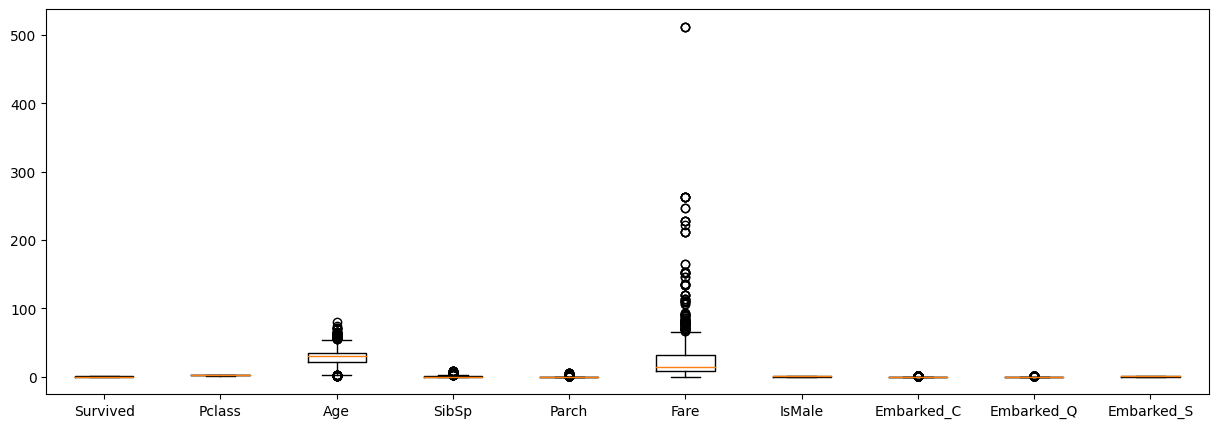

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))

ax.boxplot(treino.iloc[:,1:11])
ax.set_xticks(range(1,treino.iloc[:,1:11].shape[1]+1), treino.iloc[:,1:11].columns)

plt.show()

In [ ]:
# usando o robust scaler
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(treino[['Age','Fare']])
treino[['Age','Fare']] = transformer.transform(treino[['Age','Fare']])

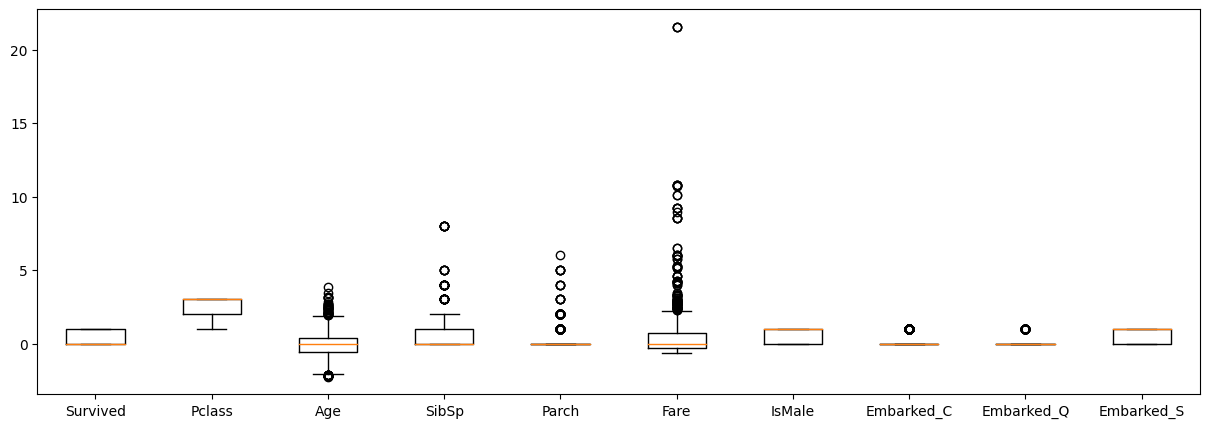

In [ ]:
# usando o grafico novamente
fig, ax = plt.subplots(figsize=(15,5))

ax.boxplot(treino.iloc[:,1:11])
ax.set_xticks(range(1,treino.iloc[:,1:11].shape[1]+1), treino.iloc[:,1:11].columns)

plt.show()

In [ ]:
# fazendo com a base de teste

transformer_tes = RobustScaler().fit(teste[['Age','Fare']])
teste[['Age','Fare']] = transformer_tes.transform(teste[['Age','Fare']])

In [ ]:
# passando os modelos de machine learn

X = treino.drop(['PassengerId', 'Survived'],axis=1)
y= treino.Survived

# treinamento com o modelo
X_train, X_val,y_train, y_val= train_test_split(X,y, test_size=0.33,random_state=42)

# realizando o modelo de arvore
clf_ac = tree.DecisionTreeClassifier(random_state=42)

# treinar o modelo de arvore
clf_ac = clf_ac.fit(X_train,y_train)

# Fazendo a previsão
y_pred_ac = clf_ac.predict(X_val)

#knn
clf_knn= KNeighborsClassifier(n_neighbors=3)
clf_knn = clf_knn.fit(X_train,y_train)
y_pred_knn = clf_knn.predict(X_val)

#regressao logistica
clf_reg = LogisticRegression(random_state=42, max_iter=1000)
clf_reg= clf_reg.fit(X_train,y_train)
y_pred_reg = clf_reg.predict(X_val)

ct_ac = accuracy_score(y_val, y_pred_ac)
ct_knn = accuracy_score(y_val, y_pred_knn)
ct_reg = accuracy_score(y_val, y_pred_reg)

ac_df['S_out'] = [ct_ac,ct_knn,ct_reg]

ac_df

,modelos,S_trat,S_out
0,arvore,0.749153,0.749153
1,knn,0.715254,0.800000
2,reg. log,0.816949,0.816949


In [ ]:
# tratando melhor os dados de sibSp e parch
SibSp_df = treino.groupby('SibSp')['Survived'].agg(['sum','count','mean']).reset_index()
SibSp_df.columns = ['SibSp','sobrev','total', 'tx_sobrev']
SibSp_df

,SibSp,sobrev,total,tx_sobrev
0,0,210,608,0.345395
1,1,112,209,0.535885
2,2,13,28,0.464286
3,3,4,16,0.250000
4,4,3,18,0.166667
5,5,0,5,0.000000
6,8,0,7,0.000000


In [ ]:
#fazendo com parch
Parch_df = treino.groupby('Parch')['Survived'].agg(['sum','count','mean']).reset_index()
Parch_df.columns = ['Parch','sobrev','total', 'tx_sobrev']
Parch_df

,Parch,sobrev,total,tx_sobrev
0,0,233,678,0.343658
1,1,65,118,0.550847
2,2,40,80,0.500000
3,3,3,5,0.600000
4,4,0,4,0.000000
5,5,1,5,0.200000
6,6,0,1,0.000000


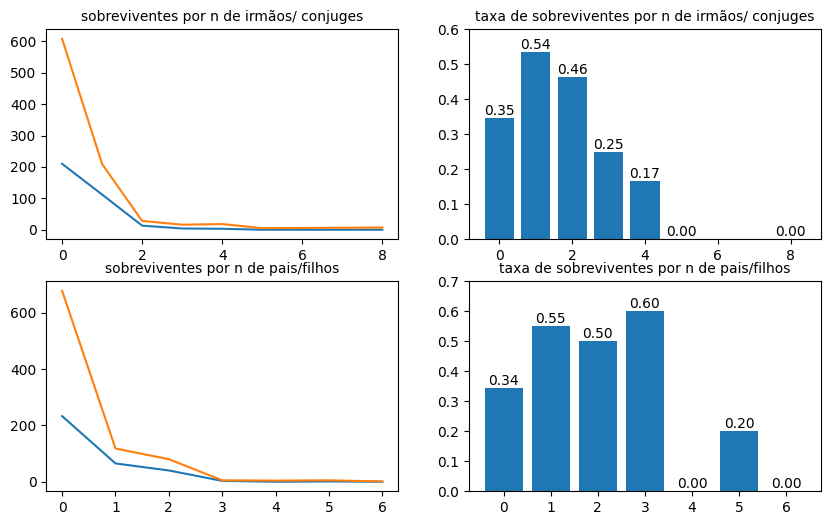

In [ ]:
# gerando grafico com as infos
fig, ax = plt.subplots(figsize=(10,6), nrows=2, ncols=2)

ax[0,0].plot(SibSp_df.SibSp, SibSp_df.sobrev)
ax[0,0].plot(SibSp_df.SibSp, SibSp_df.total)
ax[0,0].set_title('sobreviventes por n de irmãos/ conjuges', fontsize=10)

labels1 = ax[0,1].bar(SibSp_df.SibSp, SibSp_df.tx_sobrev)
ax[0,1].bar_label(labels1,fmt= '%.2f')
ax[0,1].set(ylim=(0,0.6))
ax[0,1].set_title('taxa de sobreviventes por n de irmãos/ conjuges', fontsize=10)

ax[1,0].plot(Parch_df.Parch, Parch_df.sobrev)
ax[1,0].plot(Parch_df.Parch, Parch_df.total)
ax[1,0].set_title('sobreviventes por n de pais/filhos', fontsize=10)

labels2 = ax[1,1].bar(Parch_df.Parch, Parch_df.tx_sobrev)
ax[1,1].bar_label(labels2,fmt= '%.2f')
ax[1,1].set(ylim=(0,0.7))
ax[1,1].set_title('taxa de sobreviventes por n de pais/filhos', fontsize=10)

plt.show()

In [ ]:
# percebemos que pessoas que foram sozinhas tem menor chance de sobreviver assim iremos separar elas
def sozinho(a,b):
  if(a==0 and b==0):
    return 1
  else:
    return 0

In [ ]:
# aplicando na base
treino['Sozinho'] = treino.apply(lambda x: sozinho(x.SibSp, x.Parch), axis = 1)

In [ ]:
# verificando se esta correta
treino.groupby('Sozinho')[['SibSp','Parch']].mean()

,SibSp,Parch
Sozinho,,
0,1.316384,0.960452
1,0.000000,0.000000


In [ ]:
teste['Sozinho'] = teste.apply(lambda x: sozinho(x.SibSp, x.Parch), axis = 1)

In [ ]:
# podemos somar quantos familiares eles tem SibSp + Parch
treino['familiares'] = treino.SibSp + treino.Parch
teste['familiares'] = teste.SibSp + teste.Parch

In [ ]:
familares_df= treino.groupby('familiares')['Survived'].agg(['sum','count','mean']).reset_index()
familares_df.columns = ['familiares','sobrev','total', 'tx_sobrev']

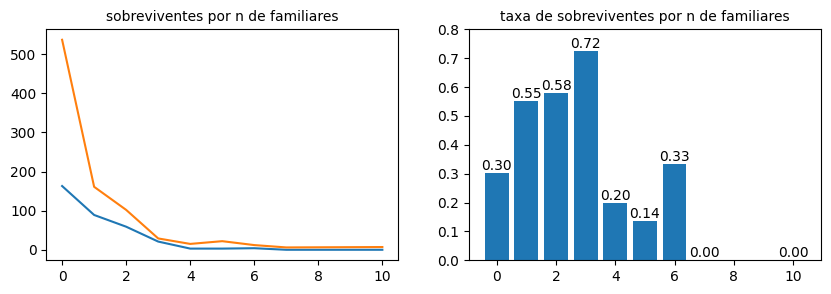

In [ ]:
# gerando grafico com as infos
fig, ax = plt.subplots(figsize=(10,3),ncols=2)

ax[0].plot(familares_df.familiares, familares_df.sobrev)
ax[0].plot(familares_df.familiares, familares_df.total)
ax[0].set_title('sobreviventes por n de familiares', fontsize=10)

labels = ax[1].bar(familares_df.familiares, familares_df.tx_sobrev)
ax[1].bar_label(labels,fmt= '%.2f')
ax[1].set(ylim=(0,0.8))
ax[1].set_title('taxa de sobreviventes por n de familiares', fontsize=10)


plt.show()

In [ ]:
# passando os modelos de machine learn

X = treino.drop(['PassengerId', 'Survived','Parch','SibSp'],axis=1)
y= treino.Survived

# treinamento com o modelo
X_train, X_val,y_train, y_val= train_test_split(X,y, test_size=0.33,random_state=42)

# realizando o modelo de arvore
clf_ac = tree.DecisionTreeClassifier(random_state=42)

# treinar o modelo de arvore
clf_ac = clf_ac.fit(X_train,y_train)

# Fazendo a previsão
y_pred_ac = clf_ac.predict(X_val)

#knn
clf_knn= KNeighborsClassifier(n_neighbors=3)
clf_knn = clf_knn.fit(X_train,y_train)
y_pred_knn = clf_knn.predict(X_val)

#regressao logistica
clf_reg = LogisticRegression(random_state=42, max_iter=1000)
clf_reg= clf_reg.fit(X_train,y_train)
y_pred_reg = clf_reg.predict(X_val)

ct1_ac = accuracy_score(y_val, y_pred_ac)
ct1_knn = accuracy_score(y_val, y_pred_knn)
ct1_reg = accuracy_score(y_val, y_pred_reg)

ac_df['pessoas'] = [ct1_ac,ct1_knn,ct1_reg]

ac_df

,modelos,S_trat,S_out,pessoas
0,arvore,0.749153,0.749153,0.752542
1,knn,0.715254,0.800000,0.789831
2,reg. log,0.816949,0.816949,0.810169


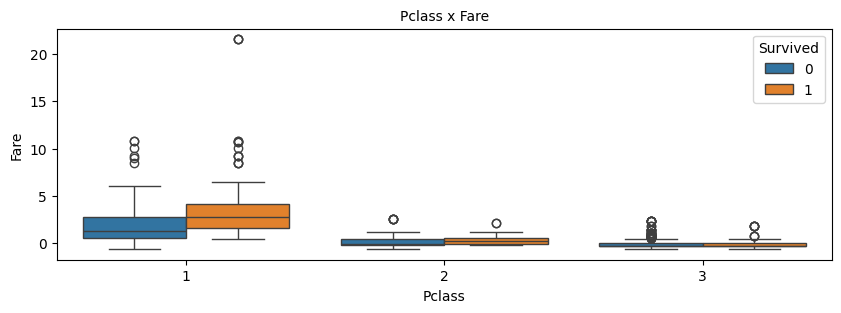

In [ ]:
fig, ax = plt.subplots(figsize=(10,3))
import seaborn as sns

sns.boxplot(data= treino,x='Pclass', y='Fare', hue='Survived')
ax.set_title('Pclass x Fare', fontsize= 10)

plt.show()

In [ ]:
treino.groupby(['Pclass','Survived'])['Fare'].agg(['mean', 'min', 'max'])

mean       min        max
Pclass Survived                               
1      0         2.175430 -0.626005  10.764405
       1         3.514735  0.496977  21.562738
2      0         0.214734 -0.626005   2.557247
       1         0.329217 -0.171255   2.189115
3      0        -0.033991 -0.626005   2.386174
       1        -0.032885 -0.626005   1.820802

In [ ]:
# melhorando a questão do embarked com o encod ja que pessoas que emabarcaram no primeiro ponto de embarked pagaram a mais
treino2 = pd.read_csv('train.csv')
teste2 = pd.read_csv('test.csv')
treino2['Embarked'] = treino2['Embarked'].fillna('S')
teste2['Embarked'] = teste2['Embarked'].fillna('S')

In [ ]:
# fazendo com o ordianl encoder
from sklearn.preprocessing import OrdinalEncoder
categorias= ['S', 'C', 'Q']
enc = OrdinalEncoder(categories=[categorias], dtype= 'int32')
enc = enc.fit(treino2[['Embarked']])
enc_test = OrdinalEncoder(categories=[categorias], dtype= 'int32')
enc_test = enc_test.fit(teste2[['Embarked']])

In [ ]:
# tranformando os dados
treino['Embarked'] = enc.transform(treino2[['Embarked']])
teste['Embarked'] = enc_test.transform(teste2[['Embarked']])

In [ ]:
treino = treino.drop(['Embarked_C','Embarked_Q','Embarked_S'],axis= 1)
teste = teste.drop(['Embarked_C','Embarked_Q','Embarked_S'],axis= 1)

In [ ]:
treino.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,IsMale,Sozinho,familiares,Embarked
PassengerId,1.000000,-0.005007,-0.035144,0.033207,-0.057527,-0.001652,0.012658,0.042939,0.057462,-0.040143,-0.030467
Survived,-0.005007,1.000000,-0.338481,-0.069809,-0.035322,0.081629,0.257307,-0.543351,-0.203367,0.016639,0.106811
Pclass,-0.035144,-0.338481,1.000000,-0.331339,0.083081,0.018443,-0.549500,0.131900,0.135207,0.065997,0.045702
Age,0.033207,-0.069809,-0.331339,1.000000,-0.232625,-0.179191,0.091566,0.084153,0.179775,-0.248512,0.007461
SibSp,-0.057527,-0.035322,0.083081,-0.232625,1.000000,0.414838,0.159651,-0.114631,-0.584471,0.890712,-0.059961
Parch,-0.001652,0.081629,0.018443,-0.179191,0.414838,1.000000,0.216225,-0.245489,-0.583398,0.783111,-0.078665
Fare,0.012658,0.257307,-0.549500,0.091566,0.159651,0.216225,1.000000,-0.182333,-0.271832,0.217138,0.062142
IsMale,0.042939,-0.543351,0.131900,0.084153,-0.114631,-0.245489,-0.182333,1.000000,0.303646,-0.200988,-0.116569
Sozinho,0.057462,-0.203367,0.135207,0.179775,-0.584471,-0.583398,-0.271832,0.303646,1.000000,-0.690922,0.017807
familiares,-0.040143,0.016639,0.065997,-0.248512,0.890712,0.783111,0.217138,-0.200988,-0.690922,1.000000,-0.080281


In [ ]:
# verificando a importancia do Sisb e do Parch

X= treino.drop(['PassengerId', 'Survived'], axis = 1)
y = treino.Survived

clf_rl = LogisticRegression(random_state=42, max_iter=1000).fit(X,y)
clf_rl.coef_[0]

array([-1.03314773, -0.49645712, -0.26819737,  0.01690958,  0.04398615,
       -2.5345877 , -0.73233826, -0.25128778,  0.23866778])

In [ ]:
# fazendo com a arvore para dar um tchan

clf_ac = tree.DecisionTreeClassifier(random_state = 42).fit(X,y)
clf_ac.feature_importances_

array([0.10901775, 0.22826711, 0.01907221, 0.0272942 , 0.23870173,
       0.30933519, 0.00397775, 0.04365035, 0.02068372])

In [ ]:
# criando um Df
imp = pd.DataFrame(
    {
        'colunas': X.columns,
        'reg. log': clf_rl.coef_[0],
        'arvore': clf_ac.feature_importances_
    }
)
imp

,colunas,reg. log,arvore
0,Pclass,-1.033148,0.109018
1,Age,-0.496457,0.228267
2,SibSp,-0.268197,0.019072
3,Parch,0.016910,0.027294
4,Fare,0.043986,0.238702
5,IsMale,-2.534588,0.309335
6,Sozinho,-0.732338,0.003978
7,familiares,-0.251288,0.043650
8,Embarked,0.238668,0.020684


In [ ]:
## passando o treino e o fit com os dados

# passando os modelos de machine learn

X = treino.drop(['PassengerId', 'Survived','SibSp','Parch'],axis=1)
y= treino.Survived

# treinamento com o modelo
X_train, X_val,y_train, y_val= train_test_split(X,y, test_size=0.33,random_state=42)

# realizando o modelo de arvore
clf_ac = tree.DecisionTreeClassifier(random_state=42)

# treinar o modelo de arvore
clf_ac = clf_ac.fit(X_train,y_train)

# Fazendo a previsão
y_pred_ac = clf_ac.predict(X_val)

#knn
clf_knn= KNeighborsClassifier(n_neighbors=3)
clf_knn = clf_knn.fit(X_train,y_train)
y_pred_knn = clf_knn.predict(X_val)

#regressao logistica
clf_reg = LogisticRegression(random_state=42, max_iter=1000)
clf_reg= clf_reg.fit(X_train,y_train)
y_pred_reg = clf_reg.predict(X_val)

ct2_ac = accuracy_score(y_val, y_pred_ac)
ct2_knn = accuracy_score(y_val, y_pred_knn)
ct2_reg = accuracy_score(y_val, y_pred_reg)

ac_df['encode'] = [ct2_ac,ct2_knn,ct2_reg]

ac_df


,modelos,S_trat,S_out,pessoas,encode
0,arvore,0.749153,0.749153,0.752542,0.762712
1,knn,0.715254,0.800000,0.789831,0.786441
2,reg. log,0.816949,0.816949,0.810169,0.810169


In [ ]:
# passando os modelos de machine learn

X = treino.drop(['PassengerId', 'Survived'],axis=1)
y= treino.Survived

# treinamento com o modelo
X_train, X_val,y_train, y_val= train_test_split(X,y, test_size=0.33,random_state=42)

# usando o modelo de random forest
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(random_state=42)

clf_rf = clf_rf.fit(X_train,y_train)

y_pred_rf = clf_rf.predict(X_val)

ct2_rf = accuracy_score(y_val, y_pred_rf)

# usando o modelo de redes neurais (MLPclassifier)

from sklearn.neural_network import MLPClassifier

clf_mlp = MLPClassifier(random_state=42, max_iter=5000)

clf_mlp = clf_mlp.fit(X_train,y_train)

y_pred_mlp = clf_mlp.predict(X_val)

ct2_mlp = accuracy_score(y_val, y_pred_mlp)


ac_df2 = pd.DataFrame(
    {
        'modelos' : ['Reg. log','forest','MLP'],
        'encode' : [ct2_reg, ct2_rf, ct2_mlp]
    }
)

ac_df2

,modelos,encode
0,Reg. log,0.810169
1,forest,0.783051
2,MLP,0.816949


In [ ]:
# verificando qual melhor parametro para cada modelo

X = treino.drop(['PassengerId', 'Survived'],axis=1)
y= treino.Survived

X_train, X_val,y_train, y_val= train_test_split(X,y, test_size=0.2,random_state=42)

clf_reg = LogisticRegression(random_state=42, max_iter=1000)

parametros_reg = {
    'penalty': ['l1','l2'],
    'C': [0.01, 0.1 ,1 ,10],
    'solver': ['lbfgs','liblinear','saga'],
    'max_iter':[100,1000,5000,10000]
}

clf_rf = RandomForestClassifier(random_state=42)

parametros_rf = {
    'n_estimators': [100,200,500,1000],
    'criterion': ['gini','entropy','log_loss'],
    'max_depth': [2,4,6,8,None],
    'max_features': ['sqrt', 'log2', None]
}

clf_mlp = MLPClassifier(random_state=42, max_iter=5000)

parametros_mlp = {
    'solver': ['lbfgs','sgd','adam'],
    'alpha': [10.0**(-1), 10.0**(-5), 10.0**(-7), 10.0**(-10)],
    'max_iter':[200,500,1000,5000]
}


In [ ]:
# agora testando cada processo , porem ignorando os avisos de falha pq sabemos que alguns parametros irão dar avisos e a hora que rodou

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

def hora_atual():
  agora = datetime.now()
  print(str(agora.hour)+':' + str(agora.minute)+':'+ str(agora.second))

In [ ]:
# importando e realizando a ação
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

hora_atual()
kfold_reg = KFold(shuffle=True,random_state=42,n_splits=8)
grind_reg= GridSearchCV(clf_reg, parametros_reg, scoring='accuracy', cv= kfold_reg)
grind_reg = grind_reg.fit(X_train, y_train)
hora_atual()


19:3:27
19:3:39


In [ ]:
hora_atual()
kfold_rf = KFold(shuffle=True,random_state=42,n_splits=8)
grind_rf= GridSearchCV(clf_rf, parametros_rf, scoring='accuracy', cv= kfold_rf)
grind_rf = grind_rf.fit(X_train, y_train)
hora_atual()

19:6:56
19:31:3


In [ ]:
hora_atual()
kfold_mlp = KFold(shuffle=True,random_state=42,n_splits=8)
grind_mlp= GridSearchCV(clf_mlp, parametros_mlp, scoring='accuracy', cv= kfold_mlp)
grind_mlp = grind_mlp.fit(X_train, y_train)
hora_atual()

19:34:3
19:47:58


In [ ]:
# vendo os mmelhores parametros para cada um
grind_reg.best_params_


{'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

In [ ]:
grind_rf.best_params_


{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'sqrt',
 'n_estimators': 500}

In [ ]:
grind_mlp.best_params_

{'alpha': 1e-10, 'max_iter': 200, 'solver': 'adam'}

In [ ]:
# melhores scores
max_rf= grind_rf.best_score_
max_reg=grind_reg.best_score_
max_mlp=grind_mlp.best_score_


ac_df2['Fit_param'] = [max_reg,max_rf,max_mlp]

ac_df2

,modelos,encode,Fit_param
0,Reg. log,0.810169,0.808989
1,forest,0.783051,0.831461
2,MLP,0.816949,0.816011


In [ ]:
clf_best_reg = grind_reg.best_estimator_
y_pred_reg = clf_best_reg.predict(X_val)

clf_best_rf = grind_rf.best_estimator_
y_pred_rf = clf_best_rf.predict(X_val)

clf_best_mlp = grind_mlp.best_estimator_
y_pred_mlp = clf_best_mlp.predict(X_val)

ac_clf_best_reg = accuracy_score(y_val, y_pred_reg)
ac_clf_best_rf = accuracy_score(y_val, y_pred_rf)
ac_clf_best_mlp = accuracy_score(y_val, y_pred_mlp)

ac_df2['Fit_param_verd'] = [ac_clf_best_reg,ac_clf_best_rf,ac_clf_best_mlp]

ac_df2

,modelos,encode,Fit_param,Fit_param_verd
0,Reg. log,0.810169,0.808989,0.804469
1,forest,0.783051,0.831461,0.798883
2,MLP,0.816949,0.816011,0.810056
